# Pendulum with Python package PyDy

In [67]:
from __future__ import print_function, division
from sympy import symbols, simplify
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
from sympy.physics.mechanics import inertia, RigidBody
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod
from numpy import deg2rad, rad2deg, array, zeros, linspace
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
import matplotlib.pyplot as plt

## Reference frames

In [2]:
inertial_frame = ReferenceFrame('I')
pendulum_frame = ReferenceFrame('P')

In [3]:
psi = dynamicsymbols('psi') #Pendulum angle

In [4]:
pendulum_frame.orient(inertial_frame, 'Axis', (psi, inertial_frame.z))

In [5]:
pendulum_frame.dcm(inertial_frame)

Matrix([
[ cos(psi), sin(psi), 0],
[-sin(psi), cos(psi), 0],
[        0,        0, 1]])

## Define some points

In [6]:
attachment = Point('A')
distance_attachment_pendulum_mass_center = symbols('L')

pendulum_mass_center = Point('cg')
pendulum_mass_center.set_pos(attachment, distance_attachment_pendulum_mass_center*pendulum_frame.x)

## Kinematical Differential Equations

In [7]:
r = dynamicsymbols('r') # Pendulum rate

In [8]:
kinematical_differential_equations = [r - psi.diff()]
kinematical_differential_equations

[r - psi']

## Angular Velocities

In [9]:
pendulum_frame.set_ang_vel(inertial_frame,r*inertial_frame.z)

In [10]:
pendulum_frame.ang_vel_in(inertial_frame)

r*I.z

## Linear Velocities

In [11]:
attachment.set_vel(inertial_frame, 0)


In [12]:
pendulum_mass_center.v2pt_theory(attachment, inertial_frame, pendulum_frame)

L*r*P.y

## Mass

In [13]:
pendulum_mass = symbols('m_P')

## Inertia

In [14]:
Izz = symbols('I_zz')

In [15]:
pendulum_dyadic = inertia(pendulum_frame, 0, 0, Izz)

In [16]:
pendulum_dyadic

I_zz*(P.z|P.z)

In [17]:
pendulum_dyadic.to_matrix(pendulum_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_zz]])

In [18]:
pendulum_central_inertia = (pendulum_dyadic, pendulum_mass_center)

In [19]:
pendulum = RigidBody('Pendulum', pendulum_mass_center, pendulum_frame,
                      pendulum_mass, pendulum_central_inertia)

## Equations of Motion

In [20]:
coordinates = [psi]
coordinates

[psi]

In [21]:
speeds = [r]
speeds

[r]

In [22]:
kane = KanesMethod(inertial_frame, coordinates, speeds, kinematical_differential_equations)

In [23]:
g = symbols('g')

In [168]:
pendulum_grav_force_vector = -pendulum_mass * g * inertial_frame.y
pendulum_grav_force_vector

- g*m_P*I.y

In [169]:
pendulum_grav_force = (pendulum_mass_center, pendulum_grav_force_vector)

In [170]:
attachement_torque = dynamicsymbols('T_a')
pendulum_torque_vector = attachement_torque * inertial_frame.z
pendulum_torque_vector

T_a*I.z

In [171]:
pendulum_torque = (pendulum_frame, pendulum_torque_vector)

In [172]:
#loads = [pendulum_grav_force,
#        pendulum_torque]
loads = [pendulum_grav_force]

loads

[(cg, - g*m_P*I.y)]

In [173]:
bodies = [pendulum]

In [174]:
fr, frstar = kane.kanes_equations(bodies = bodies,loads = loads)

In [175]:
trigsimp(fr + frstar)

Matrix([[-L*g*m_P*cos(psi) - (I_zz + L**2*m_P)*r']])

In [176]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1,               0],
[0, I_zz + L**2*m_P]])

In [177]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                r],
[-L*g*m_P*cos(psi)]])

## Simulation

In [178]:
constants = [distance_attachment_pendulum_mass_center,
             pendulum_mass,            
             Izz,
             g]

In [179]:
coordinates = [psi]
coordinates

[psi]

In [180]:
speeds = [r]
speeds

[r]

In [181]:
#specified = [pendulum_torque]
specified = []


right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [182]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(2,)
        The state vector is ordered as such:
            - psi(t)
            - r(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(0,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 0. If the value is a
        function it must be of the form g(x, t), where x is the current state
        vector ndarray and 

## Set the Initial Conditions, Parameter Values, and Time Array

In [197]:
x0 = array([deg2rad(20),0])
x0

array([0.34906585, 0.        ])

In [213]:
numerical_constants = array([
                             1,  # pendulum_length [m]
                             1,  # pendulum_mass [kg]
                             10,  # pendulum_inertia [kg*m^2]
                             9.81],  # acceleration due to gravity [m/s^2]
                            ) 

In [214]:
# %load exercise_solutions/n07_simulation_sim-setup.py
numerical_specified = zeros(3)

args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 60
final_time = 5.0

t = linspace(0.0, final_time, final_time * frames_per_sec)

/Users/martinalexandersson/Dev/ForceMan/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


In [215]:
numerical_specified = array([0.0])

args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 60
final_time = 10.0

t = linspace(0.0, final_time, final_time * frames_per_sec)

/Users/martinalexandersson/Dev/ForceMan/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [216]:
right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

array([ 0.        , -0.83803496])

## Integrate the Equations of Motion

In [217]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

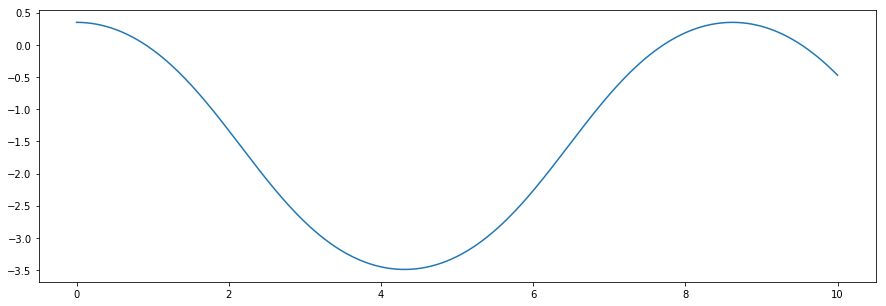

In [218]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(t,y[:,0])

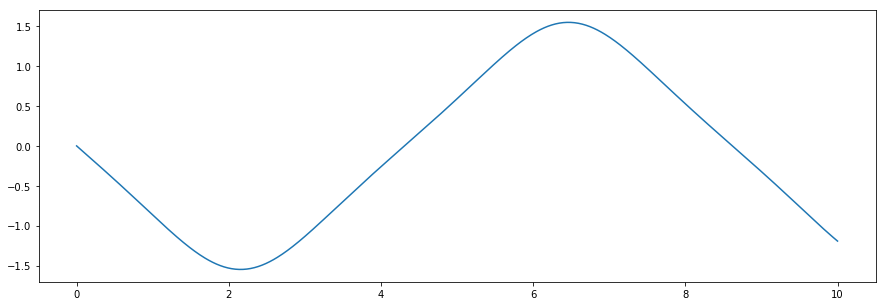

In [219]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(t,y[:,1])